## Multi-modal Retrieval with MS-COCO Dataset

#### Objectives 

- Generate embeddings for text and images in a shared latent space.
- Retrieve images based on textual descriptions (text-to-image retrieval) or vice versa (image-to-text retrieval).
- Evaluate retrieval performance using standard metrics like Recall@K and Mean Average Precision (MAP).

#### Setup

Dataset: Use a dataset with text and images (e.g., MS-COCO or a custom dataset). The dataset should have the following:

- Text: Descriptions.
- Images: Associated images.

In [1]:
# %pip install fiftyone
# %pip install pycocotools transformers 
# %pip install sentence-transformers

#### Step 1: Load MS-COCO dataset
- The MS-COCO dataset can be loaded using the pycocotools library, which provides easy access to annotations and images.
- The ground truth labels are the image-caption pairs provided in the MS-COCO dataset. Each image has 5 captions, and these pairs serve as the basis for retrieval tasks.

In [2]:
# import fiftyone as fo
# import fiftyone.zoo as foz

# dataset = foz.load_zoo_dataset(
#     "coco-2017",
#     max_samples=1000,  # Only download first 1000 samples
#     shuffle=True       # Optional: get a random sample
# )

# print(dataset.info)


loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
Image ID: 391895


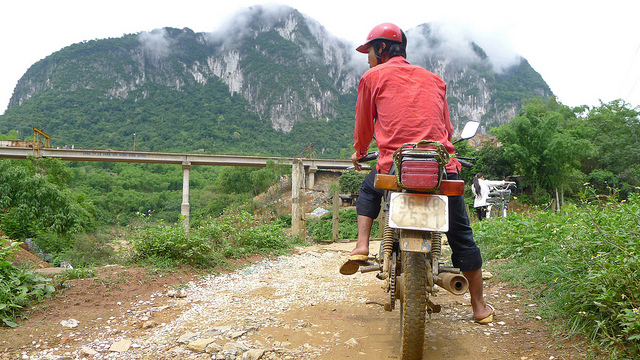

Captions:
A man with a red helmet on a small moped on a dirt road. 
Man riding a motor bike on a dirt road on the countryside.
A man riding on the back of a motorcycle.
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
A man in a red shirt and a red hat is on a motorcycle on a hill side.


In [3]:
%matplotlib inline
from pycocotools.coco import COCO
import requests
from PIL import Image
import numpy as np
from IPython.display import display

# Initialize COCO API for annotations
data_dir = '/home/azureuser/fiftyone/coco-2017/raw'
ann_file = f'{data_dir}/captions_train2017.json'
coco = COCO(ann_file)

# Load image and caption data
image_ids = coco.getImgIds()
image_id = image_ids[0]  # Example: First image
image_info = coco.loadImgs(image_id)[0]
caption_ids = coco.getAnnIds(imgIds=image_id)
captions = coco.loadAnns(caption_ids)

# Display image and captions
image_url = image_info['coco_url']
image = Image.open(requests.get(image_url, stream=True).raw)
print("Image ID:", image_id)
display(image)
print("Captions:")
for caption in captions:
    print(caption['caption'])

#### Step 2: Embedding Generation
- Generate text and image embeddings using CLIP.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Generate embeddings for all images and captions
image_ids = coco.getImgIds()[:1000]  # Use a subset for demonstration
image_embeddings = []
text_embeddings = []

for image_id in image_ids:
    # Image embedding
    image_info = coco.loadImgs(image_id)[0]
    image_url = image_info['coco_url']
    image = Image.open(requests.get(image_url, stream=True).raw)
    inputs = processor(images=image, return_tensors="pt", padding=True)
    image_embedding = model.get_image_features(**inputs).detach().numpy()
    image_embeddings.append(image_embedding)

    # Text embedding (use the first caption for simplicity)
    caption_ids = coco.getAnnIds(imgIds=image_id)
    caption = coco.loadAnns(caption_ids)[0]['caption']
    inputs = processor(text=caption, return_tensors="pt", padding=True)
    text_embedding = model.get_text_features(**inputs).detach().numpy()
    text_embeddings.append(text_embedding)


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Step 3: Embedding Alignment
- Trains a projection layer to align text and image embeddings using contrastive loss.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class ProjectionLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

def contrastive_loss(text_embeddings, image_embeddings, temperature=0.1):
    """
    Compute contrastive loss for embedding alignment.
    
    Args:
        text_embeddings (torch.Tensor): Text embeddings.
        image_embeddings (torch.Tensor): Image embeddings.
        temperature (float): Temperature parameter for scaling.
    
    Returns:
        loss (torch.Tensor): Contrastive loss.
    """
    # Normalize embeddings
    text_embeddings = torch.nn.functional.normalize(text_embeddings, dim=1)
    image_embeddings = torch.nn.functional.normalize(image_embeddings, dim=1)

    # Compute similarity matrix
    similarity_matrix = torch.matmul(text_embeddings, image_embeddings.T) / temperature

    # Compute contrastive loss
    labels = torch.arange(len(text_embeddings)).to(text_embeddings.device)
    loss_text = torch.nn.functional.cross_entropy(similarity_matrix, labels)
    loss_image = torch.nn.functional.cross_entropy(similarity_matrix.T, labels)
    return (loss_text + loss_image) / 2

def train_projection_layer(text_embeddings, image_embeddings, epochs=10, lr=1e-4):
    """
    Train a projection layer to align text and image embeddings.
    
    Args:
        text_embeddings (np.array): Text embeddings.
        image_embeddings (np.array): Image embeddings.
        epochs (int): Number of training epochs.
        lr (float): Learning rate.
    
    Returns:
        text_projection (nn.Module): Trained text projection layer.
        image_projection (nn.Module): Trained image projection layer.
    """
    # Convert embeddings to PyTorch tensors
    text_embeddings = torch.tensor(text_embeddings, dtype=torch.float32)
    image_embeddings = torch.tensor(image_embeddings, dtype=torch.float32)

    # Initialize projection layers
    text_projection = ProjectionLayer(512, 256)  # CLIP embedding dim: 512
    image_projection = ProjectionLayer(512, 256)

    # Initialize optimizer
    optimizer = optim.Adam(list(text_projection.parameters()) + list(image_projection.parameters()), lr=lr)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Project embeddings
        projected_text = text_projection(text_embeddings)
        projected_image = image_projection(image_embeddings)

        # Compute contrastive loss
        loss = contrastive_loss(projected_text, projected_image)
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    return text_projection, image_projection

#### Step 4: Text-based retrieval
- Retrieves the top-K most similar images given a query text and precomputed embeddings.

In [6]:
def text_based_retrieval(query_text, text_embeddings, image_embeddings, image_ids, processor, model, text_projection=None, k=5):
    """
    Perform text-to-image retrieval using cosine similarity and return raw image IDs.
    
    Args:
        query_text (str): The query text.
        text_embeddings (list): List of text embeddings for all captions.
        image_embeddings (list): List of image embeddings for all images.
        image_ids (list): List of raw image IDs corresponding to the embeddings.
        processor: CLIP processor for tokenization.
        model: CLIP model for generating embeddings.
        text_projection (nn.Module): Projection layer for text embeddings (optional).
        k (int): Number of top results to retrieve.
    
    Returns:
        retrieved_image_ids (list): Raw image IDs of the top-K retrieved images.
    """
    # Generate query embedding
    inputs = processor(text=query_text, return_tensors="pt", padding=True)
    query_embedding = model.get_text_features(**inputs).detach().numpy()

    # Project query embedding if a projection layer is provided
    if text_projection:
        query_embedding = text_projection(torch.tensor(query_embedding, dtype=torch.float32)).detach().numpy()

    # Compute cosine similarity between query and image embeddings
    similarities = cosine_similarity(query_embedding, np.vstack(image_embeddings))
    retrieved_indices = np.argsort(similarities[0])[::-1][:k]  # Sort by similarity and get top-K

    # Map retrieved indices to raw image IDs
    retrieved_image_ids = [image_ids[idx] for idx in retrieved_indices]

    return retrieved_image_ids

#### Step 5: Define Evaluation Metrics
Define evaluation metrics like recall@k and average precision.

In [7]:
def recall_at_k(relevant_items, retrieved_items, k):
    relevant_set = set(relevant_items)
    retrieved_set = set(retrieved_items[:k])
    return len(relevant_set.intersection(retrieved_set)) / len(relevant_set)

def average_precision(relevant_items, retrieved_items):
    relevant_set = set(relevant_items)
    precision_scores = []
    num_relevant = 0
    for i, item in enumerate(retrieved_items):
        if item in relevant_set:
            num_relevant += 1
            precision_scores.append(num_relevant / (i + 1))
    return sum(precision_scores) / len(relevant_set) if relevant_set else 0

#### Step 6: Evaluation Comparison Between Unaligned and Aligned Embeddings

In [23]:
from pycocotools.coco import COCO
import re

def extract_keywords(text):
    """
    Extract lowercase keywords from query text (excluding stopwords).
    """
    stopwords = {"the", "a", "an", "in", "on", "of", "and", "to", "for", "with", "at", "by", "from"}
    words = re.findall(r'\b\w+\b', text.lower())
    return [word for word in words if word not in stopwords]

def find_relevant_images_keywords_simple(coco, query_text):
    """
    Find relevant image indices where all query keywords are contained in captions.

    Args:
        coco (COCO): Initialized COCO object.
        query_text (str): User query.

    Returns:
        tuple: (relevant_image_ids, captions_per_image, match_scores)
    """
    query_keywords = extract_keywords(query_text)
    image_ids = coco.getImgIds()

    relevant_ids = []
    relevant_captions = []
    match_scores = []

    for img_id in image_ids:
        ann_ids = coco.getAnnIds(imgIds=img_id)
        captions = [ann['caption'] for ann in coco.loadAnns(ann_ids)]
        full_caption_text = " ".join(captions).lower()

        # Match score: 1 if all query keywords in captions, else 0
        is_match = all(keyword in full_caption_text for keyword in query_keywords)
        score = 1 if is_match else 0

        if score:
            relevant_ids.append(img_id)
            relevant_captions.append(captions)
            match_scores.append(score)

    return relevant_ids, relevant_captions, match_scores

In [9]:
# Train projection layer to get aligned embeddings
text_projection, image_projection = train_projection_layer(np.vstack(text_embeddings), np.vstack(image_embeddings))

# Generate aligned embeddings
aligned_text_embeddings = text_projection(torch.tensor(np.vstack(text_embeddings), dtype=torch.float32)).detach().numpy()
aligned_image_embeddings = image_projection(torch.tensor(np.vstack(image_embeddings), dtype=torch.float32)).detach().numpy()


Epoch 1, Loss: 7.002729892730713
Epoch 2, Loss: 6.939802169799805
Epoch 3, Loss: 6.878083229064941
Epoch 4, Loss: 6.817410469055176
Epoch 5, Loss: 6.757604598999023
Epoch 6, Loss: 6.698486328125
Epoch 7, Loss: 6.639886379241943
Epoch 8, Loss: 6.581648826599121
Epoch 9, Loss: 6.523638725280762
Epoch 10, Loss: 6.465744495391846
Recall@5 (Unaligned): 0.0
Recall@5 (Aligned): 0.0
MAP@5 (Unaligned): 0.0
MAP@5 (Aligned): 0.0


In [38]:
k = 10
query_text = "A cat in a livingroom"
relevant_indices,_,_ = find_relevant_images_keywords_simple(coco, query_text)

# Perform retrieval with unaligned embeddings
unaligned_retrieved_indices = text_based_retrieval(query_text, text_embeddings, image_embeddings, image_ids, processor, model, k=k)
unaligned_recall = recall_at_k(relevant_indices, unaligned_retrieved_indices, k=k)
unaligned_map = average_precision(relevant_indices, unaligned_retrieved_indices)

# Perform retrieval with aligned embeddings
aligned_retrieved_indices = text_based_retrieval(query_text, aligned_text_embeddings, aligned_image_embeddings, image_ids, processor, model, text_projection=text_projection, k=k)
aligned_recall = recall_at_k(relevant_indices, aligned_retrieved_indices, k=k)
aligned_map = average_precision(relevant_indices, aligned_retrieved_indices)

print(f"Recall@{k:<2} (Unaligned): {unaligned_recall:.4f}")
print(f"Recall@{k:<2} (Aligned)  : {aligned_recall:.4f}")
print(f"MAP@{k:<5} (Unaligned): {unaligned_map:.4f}")
print(f"MAP@{k:<5} (Aligned)  : {aligned_map:.4f}")

print("Relevant: ", relevant_indices)
print("Unaligned: ", unaligned_retrieved_indices)
print("Aligned: ", aligned_retrieved_indices)

Recall@10 (Unaligned): 0.0000
Recall@10 (Aligned)  : 0.0000
MAP@10    (Unaligned): 0.0000
MAP@10    (Aligned)  : 0.0000
Relevant:  [108442, 201738]
Unaligned:  [37907, 480076, 10694, 384204, 578498, 143824, 309852, 372979, 546702, 196311]
Aligned:  [232383, 152751, 37907, 346207, 145199, 384213, 353968, 40986, 79472, 389624]


Image ID: 40986


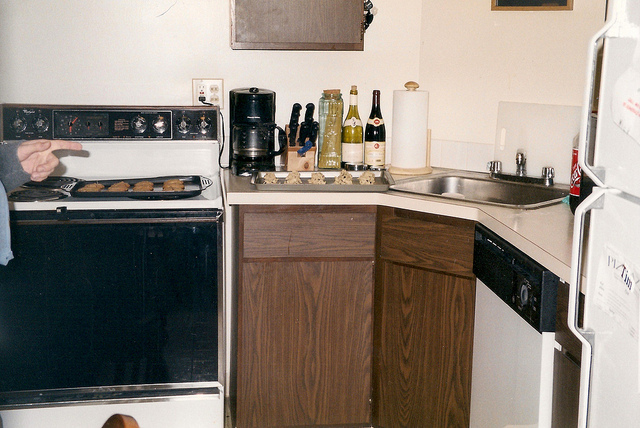

Captions:
Raw cookies in a pan on the counter and baked cookies in a pan on the stove.
Assorted items on a counter top in a kitchenette.
A man points at the wall in his kitchen.
Two pans with cookies in them sitting on a counter with liquor bottles, a coffee maker and knives.
A countertop in a kitchen with fresh cookies.


In [41]:
image_id = 40986
image_info = coco.loadImgs(image_id)[0]
caption_ids = coco.getAnnIds(imgIds=image_id)
captions = coco.loadAnns(caption_ids)

# Display image and captions
image_url = image_info['coco_url']
image = Image.open(requests.get(image_url, stream=True).raw)
print("Image ID:", image_id)
display(image)
print("Captions:")
for caption in captions:
    print(caption['caption'])